<a href="https://colab.research.google.com/github/nam157/Pneumonia_Chestxray/blob/main/pneumonia_chestxray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting configs colab

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [81]:
!nvidia-smi

Fri Mar 24 15:20:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |   7593MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# method balance datasets

In [ ]:
def weight_random_sampler(df, train_ds):
    from torch.utils.data import WeightedRandomSampler

    class_counts = df.label.value_counts()
    class_weights = 1 / class_counts
    sample_weights = [class_weights[i] for i in df.label.values]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_ds))

    return sampler

# Load datasets

In [84]:
!pip install torchsampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
import glob
import os
from typing import List

import numpy as np
import pandas as pd
import PIL
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchsampler import ImbalancedDatasetSampler
from torchvision.transforms import transforms as trns


def create_data(data_dir: os.pardir, save_file: str) -> pd.DataFrame:
    """
    It takes in the data directory and the name of the file to save the data to, and returns a pandas
    dataframe with the image paths and labels

    :param data_dir: The directory where the data is stored
    :type data_dir: os.pardir
    :param save_file: The name of the file to save the data to
    :type save_file: str
    :return: A dataframe with the image and label columns.
    """
    normal_cases_dir = os.path.join(data_dir, "NORMAL")
    pneumonia_cases_dir = os.path.join(data_dir, "PNEUMONIA")

    normal_cases = glob.glob(f"{normal_cases_dir}/*.jpeg")
    pneumonia_cases = glob.glob(f"{pneumonia_cases_dir}/*.jpeg")

    data = []

    for img in normal_cases:
        data.append((img, 0))

    for img in pneumonia_cases:
        data.append((img, 1))

    data = pd.DataFrame(data, columns=["image", "label"], index=None)

    data = data.sample(frac=1.0).reset_index(drop=True)

    os.makedirs("data_chestxray", exist_ok=True)
    data.to_csv(os.path.join("data_chestxray/", save_file), index=False)
    return data


def concat_dataset(
    train_dir: str = "chest_xray/train",
    test_dir: str = "chest_xray/test",
    val_dir: str = "chest_xray/val",
) -> pd.DataFrame:
    """
    It takes in the train and validation directory and creates a dataframe for each of them. Then it
    concatenates the two dataframes and returns the concatenated dataframe

    :param train_dir: The directory where the training data is stored, defaults to chest_xray/train
    :type train_dir: str (optional)
    :param val_dir: The directory where the validation data is stored, defaults to chest_xray/val
    :type val_dir: str (optional)
    :return: A dataframe with the image paths and labels for the train and validation sets.
    """
    data_train = create_data(data_dir=train_dir, save_file="train.csv")
    if test_dir:
        data_test = create_data(data_dir=test_dir, save_file="test.csv")
    else:
        data_test = None
    if val_dir:
        data_validation = create_data(data_dir=val_dir, save_file="val.csv")
    else:
        data_validation = None

    data_merge = (
        pd.concat([data_train, data_validation, data_test], axis=0)
        .reset_index()
        .drop(["index"], axis=1)
    )

    return data_merge


def data_augmentations(img_size: float = 224):
    """
    It takes an image, resizes it to 224x224, flips it horizontally, converts it to a tensor, and
    normalizes it

    :param img_size: The size of the image to be resized to, defaults to 224
    :type img_size: float (optional)
    :return: the train_transforms, val_transforms, and test_transforms.
    """

    train_transforms = trns.Compose(
        [
            trns.CenterCrop(img_size),
            trns.RandomHorizontalFlip(),
            trns.RandomVerticalFlip(),
            trns.ToTensor(),
            trns.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    val_transforms = trns.Compose(
        [
            trns.Resize(size=img_size),
            trns.ToTensor(),
            trns.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    test_transforms = trns.Compose(
        [
            trns.Resize(size=img_size),
            trns.ToTensor(),
            trns.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    return train_transforms, val_transforms, test_transforms


class ChestXrayDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transforms: List = None) -> None:
        """
        This function takes in a dataframe and a list of transforms and assigns the dataframe to the
        class variable df and the list of transforms to the class variable transforms

        :param df: The dataframe containing the data
        :type df: pd.DataFrame
        :param transforms: List = None
        :type transforms: List
        """
        self.df = df
        self.transforms = transforms
        self.labels = self.get_labels()

    def get_labels(self):
        labels = self.df["label"].values
        return labels

    def __len__(self):
        """
        The function returns the number of rows in the dataframe
        :return: The number of rows in the dataframe.
        """
        return self.df.shape[0]

    def _get_image(self, path) -> PIL.Image:
        """
        It takes a path to an image, opens it, converts it to RGB, and returns the image

        :param path: The path to the image you want to classify
        :return: The image data is being returned.
        """
        imageData = Image.open(path).convert("RGB")
        return imageData

    def __getitem__(self, index: int):
        """
        It takes an index as input, and returns a tuple of the image and the target label

        :param index: the index of the image in the dataset
        :type index: int
        :return: The image and the target
        """
        target = self.labels[index]
        img = self._get_image(self.df.loc[index]["image"])
        if self.transforms:
            img = self.transforms(img)
        return img, target


def prepare_dataloader(df: pd.DataFrame, trn_idx: np.ndarray, val_idx: np.ndarray):
    """
    > We take the training and validation indices, and use them to create two datasets, one for training
    and one for validation. We then create two dataloaders, one for training and one for validation

    :param df: the dataframe containing the image paths and labels
    :type df: pd.DataFrame
    :param trn_idx: the indices of the training set
    :type trn_idx: np.ndarray
    :param val_idx: the validation indices
    :type val_idx: np.ndarray
    :return: train_loader and val_loader
    """
    train_ = df.loc[trn_idx, :].reset_index(drop=True)
    valid_ = df.loc[val_idx, :].reset_index(drop=True)

    train_transforms, val_transforms, test_transforms = data_augmentations(img_size=224)

    train_ds = ChestXrayDataset(df=train_, transforms=train_transforms)
    valid_ds = ChestXrayDataset(df=valid_, transforms=train_transforms)


    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=16,
        pin_memory=False,
        drop_last=False,
        shuffle=False,
        num_workers=2,
        # sampler=ImbalancedDatasetSampler(train_ds)
        sampler=weight_random_sampler(df=train_, train_ds=train_ds),
    )

    val_loader = torch.utils.data.DataLoader(
        valid_ds,
        batch_size=4,
        num_workers=2,
        shuffle=False,
        pin_memory=False,
        # sampler=ImbalancedDatasetSampler(valid_ds)
        sampler=weight_random_sampler(df=valid_, train_ds=valid_ds),
    )
    return train_loader, val_loader


# Plot data

In [86]:
train_data = create_data(data_dir='./drive/MyDrive/chest_xray/train/',save_file = 'train.csv')
data_merge = concat_dataset(train_dir = './drive/MyDrive/chest_xray/train/',test_dir = './drive/MyDrive/chest_xray/test/',val_dir='./drive/MyDrive/chest_xray/val/')

1    3885
0    1351
Name: label, dtype: int64


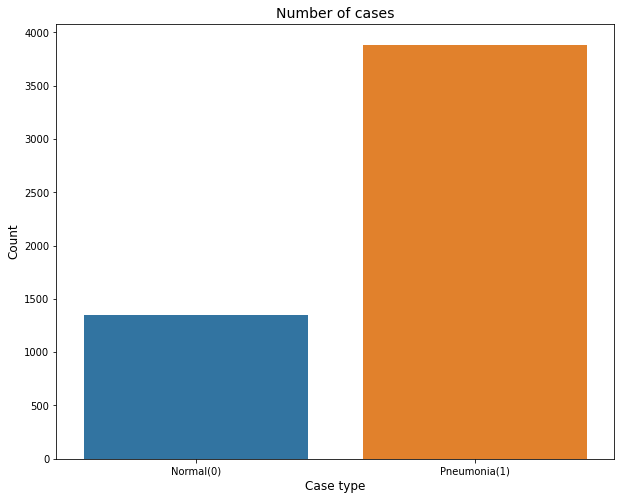

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns 

cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

1    4283
0    1593
Name: label, dtype: int64


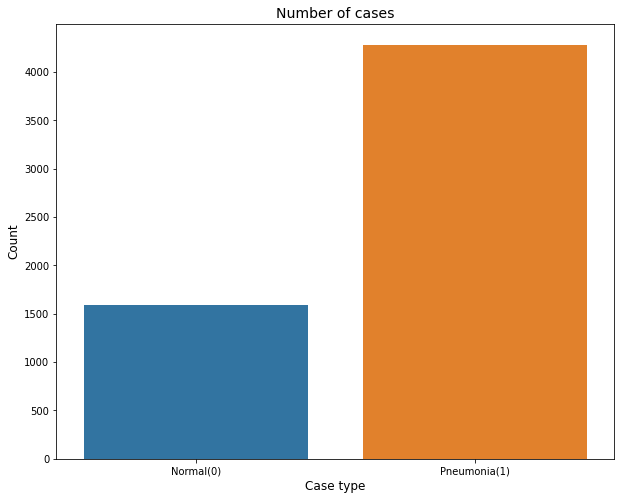

In [88]:
cases_count = data_merge['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

# models CNN

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 16.4 MB/s eta 0:00:00


In [ ]:
!pip install timm
import timm
import torch.nn as nn


# > We're creating a classifier that takes in a model architecture, number of classes, and a
# pretrained flag.
#
# The classifier class inherits from the nn.Module class. This is a class that PyTorch provides to
# help us create our own neural network modules.
#
# The classifier class has two methods:
#
# 1. __init__: This is the constructor method. It's called when we create an instance of the
# classifier class.
# 2. forward: This is the method that's called when we pass data through the classifier.
#
# Let's look at the __init__ method first.
#
# The first line of the __init__ method is:
class Classifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(n_features, n_class), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

# training-evaluate

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install wandb
import time

import numpy as np
import torch
from sklearn.metrics import (confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.cuda.amp import autocast
from tqdm import tqdm
import wandb


def train_one_epoch(
    epoch: int,
    model: Classifier,
    loss_fn,
    optimizer: torch.optim,
    train_loader: torch.utils.data.DataLoader,
    device: torch.device,
) -> float:
    """
    > We iterate through the training data, and for each batch, we pass the images through the model,
    calculate the loss, and update the model parameters

    :param epoch: the current epoch number
    :param model: the model we're training
    :param loss_fn: the loss function to use
    :param optimizer: The optimizer to use for training
    :param train_loader: the training data loader
    :param device: the device to run the training on
    :return: The average loss per batch
    """

    model.train()

    running_loss = []

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device)
        optimizer.zero_grad()
        image_preds = model(imgs)
        loss = loss_fn(image_preds.squeeze(1), image_labels.float())
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
    return sum(running_loss) / len(running_loss)


def valid_one_epoch(
    epoch: int,
    model: Classifier,
    loss_fn,
    val_loader: torch.utils.data.DataLoader,
    device: torch.device,
    logger,
):
    """
    It takes in the model, the loss function, the validation data loader, the device, the best
    validation accuracy, and the fold number.

    It then runs the model on the validation data, and calculates the validation loss and accuracy.

    If the validation accuracy is better than the best validation accuracy, it saves the model.

    It returns the best validation accuracy.

    :param epoch: the current epoch number
    :param model: the model we're training
    :param loss_fn: the loss function we're using
    :param val_loader: the validation data loader
    :param device: the device to run the training on
    :param best_val: the best validation accuracy we've seen so far
    :param fold: the fold number
    :return: The best validation accuracy
    """
    model.eval()
    validation_loss = 0.0
    image_preds_all = []
    image_targets_all = []

    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).float()

        image_preds = model(imgs)
        image_preds_all += [
            (image_preds.squeeze(1) > 0.5).float().detach().cpu().numpy()
        ]
        image_targets_all += [image_labels.detach().cpu().numpy()]

        loss = loss_fn(image_preds.squeeze(1), image_labels)

        validation_loss += loss.item()

    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)

    logger.info("image_preds_all: {}".format(image_preds_all))
    logger.info("image_targets_all: {}".format(image_targets_all))

    valid_acc = (image_preds_all == image_targets_all).mean()
    valid_f1 = f1_score(
        y_true=image_targets_all, y_pred=image_preds_all, average="binary"
    )
    valid_precision = precision_score(
        y_true=image_targets_all, y_pred=image_preds_all, average="binary"
    )
    valid_recall = recall_score(
        y_true=image_targets_all, y_pred=image_preds_all, average="binary"
    )
    confusionmatrix = confusion_matrix(y_true=image_targets_all, y_pred=image_preds_all)

    wandb.log(
        {
            "acc-valid": valid_acc,
            "F1-valid": valid_f1,
            "precision-valid": valid_precision,
            "recall-valid": valid_recall,
        }
    )
    wandb.log(
        {
            "conf_mat": wandb.plot.confusion_matrix(probs=None,
                preds=image_preds_all,
                y_true=image_targets_all,
                class_names=["Normal", "Pneumonia"],
            )
        }
    )

    logger.info("validation  accuracy = {:.4f}".format(valid_acc))
    logger.info("Validation F1-Score = {:.4f}".format(valid_f1))
    logger.info("Validation Pecision-Score = {:.4f}".format(valid_precision))
    logger.info("Validation Recall-Score = {:.4f}".format(valid_recall))
    logger.info("Confusion matrix = {}".format(confusionmatrix))

    return validation_loss / len(val_loader)


# MAIN

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import logging

import numpy as np
import torch
import wandb
from sklearn.model_selection import StratifiedKFold
from torch import nn
from torch.cuda.amp import GradScaler
from tqdm import tqdm

In [ ]:
os.makedirs('logs',exist_ok=True)

logging.basicConfig(
    filename="logs/train.log",
    filemode="a",
    format="%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

def main():
    wdb = wandb.init(
        project="pneumonia_chestxray",
        config={
            "optimizer": "AdamW",
            "learning_rate": 0.0005,
            "architecture": "mobilenetv3_large_100",
            "epochs": 30,
            "Loss": "BCEWithLogitsLoss",
        },
    )
    logging.info("Create dataset")
    device = torch.device("cuda")

    #change link datasets
    dataset = concat_dataset(
        train_dir="/content/drive/MyDrive/chest_xray/train", val_dir="/content/drive/MyDrive/chest_xray/val", test_dir=None
    )
    folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1).split(
        np.arange(dataset.shape[0]), dataset.label.values
    )
    for fold, (trn_idx, val_idx) in enumerate(folds):
        if fold > 0:
            break

        train_loader, val_loader = prepare_dataloader(
            df=dataset, trn_idx=trn_idx, val_idx=val_idx
        )
        logging.info("Load model mobilenetv3_large_100")
        model = Classifier(
            model_arch="mobilenetv3_large_100", n_class=1, pretrained=True
        ).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

        # loss = get_weighted_loss(pos_weights=[0.2703210382513661],neg_weights=[0.7296789617486339])
        # loss = FocalLoss(gamma=0.5,alpha=0.25).to(device)
        loss = nn.BCELoss().to(device)

        for epoch in range(30):
            running_loss = train_one_epoch(
                epoch=epoch,
                model=model,
                loss_fn=loss,
                optimizer=optimizer,
                train_loader=train_loader,
                device=device,
            )
            description = f"epoch {epoch} loss: {running_loss:.4f}"
            logging.info("TRAIN: {}".format(description))
            validation_loss = valid_one_epoch(
                epoch=epoch,
                model=model,
                loss_fn=loss,
                val_loader=val_loader,
                device=device,
                logger=logging,
            )
            description = f"epoch {epoch} loss: {validation_loss:.4f}"
            wdb.log({"loss-train": running_loss, "loss-valid": validation_loss})
            logging.info("VALID: {}".format(description))
            scheduler.step()

            os.makedirs("./saved_model",exist_ok=True)
            torch.save(
                model.state_dict(),
                "saved_model/{}_fold_{}_{}.pt".format(
                    "mobilenetv3_large_100", fold, epoch
                ),
            )

        del model, optimizer, train_loader, val_loader, scheduler
        torch.cuda.empty_cache()


if __name__ == "__main__":
    main()
    #api wandb: 6e8a28dad765e9632003f8ba8c03432344f028c6

<IPython.core.display.Javascript object>

# Test DCGan

#### move datasets to others folder

In [8]:
import os
os.makedirs("dataset/data_normal",exist_ok=True)
!cp -a /content/drive/MyDrive/chest_xray/train/NORMAL /content/dataset/data_normal

os.makedirs("dataset/data_normal_1",exist_ok=True)
!cp -a /content/drive/MyDrive/chest_xray/test/NORMAL /content/dataset/data_normal_1

os.makedirs("dataset/data_normal_2",exist_ok=True)
!cp -a /content/drive/MyDrive/chest_xray/val/NORMAL /content/dataset/data_normal_2

os.makedirs("dataset_total_normal",exist_ok=True)
!mv  /content/dataset/data_normal/NORMAL/* ./dataset_total_normal
!mv  /content/dataset/data_normal_1/NORMAL/* ./dataset_total_normal
!mv  /content/dataset/data_normal_2/NORMAL/* ./dataset_total_normal

os.makedirs("datasets/data_normal",exist_ok=True)
!mv  /content/dataset_total_normal/* ./datasets/data_normal

In [70]:
import os
os.makedirs("dataset/data_abnormal",exist_ok=True)
!cp -a /content/drive/MyDrive/chest_xray/train/PNEUMONIA /content/dataset/data_abnormal

os.makedirs("dataset/data_abnormal_1",exist_ok=True)
!cp -a /content/drive/MyDrive/chest_xray/test/PNEUMONIA /content/dataset/data_abnormal_1

os.makedirs("dataset/data_abnormal_2",exist_ok=True)
!cp -a /content/drive/MyDrive/chest_xray/val/PNEUMONIA /content/dataset/data_abnormal_2

os.makedirs("dataset_total_abnormal/abnormal",exist_ok=True)
!mv  /content/dataset/data_abnormal/PNEUMONIA/* ./dataset_total_abnormal/abnormal
!mv  /content/dataset/data_abnormal_1/PNEUMONIA/* ./dataset_total_abnormal/abnormal
!mv  /content/dataset/data_abnormal_2/PNEUMONIA/* ./dataset_total_abnormal/abnormal

#### Create model GAN

In [16]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [33]:
# Root directory for dataset
dataroot = "/content/datasets"
# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 128
# Spatial size of training images. All images will be resized to this
# size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 100
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [34]:
dataset = dset.ImageFolder(root=dataroot,
            transform=transforms.Compose([
                transforms.Resize(image_size),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [35]:
data = next(iter(dataset))

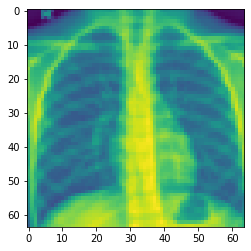

torch.Size([3, 64, 64])

In [36]:
import matplotlib.pyplot as plt

plt.imshow(data[0][1,:])
plt.show()
data[0].shape

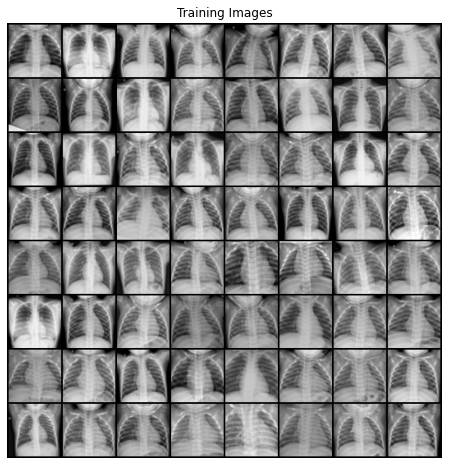

In [37]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [38]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [39]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [40]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [41]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [42]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [45]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

#### Training

In [46]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        #save models
        torch.save(netD,'netD.pth')
        torch.save(netG,'netG.pth')

Starting Training Loop...
[0/100][0/13]	Loss_D: 0.1147	Loss_G: 11.5688	D(x): 0.9992	D(G(z)): 0.1038 / 0.0000
[1/100][0/13]	Loss_D: 0.5390	Loss_G: 23.7443	D(x): 0.9991	D(G(z)): 0.3613 / 0.0000
[2/100][0/13]	Loss_D: 0.2270	Loss_G: 24.3172	D(x): 0.9980	D(G(z)): 0.1671 / 0.0000
[3/100][0/13]	Loss_D: 0.0007	Loss_G: 36.4543	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[4/100][0/13]	Loss_D: 8.5308	Loss_G: 29.9057	D(x): 0.0239	D(G(z)): 0.0000 / 0.0000
[5/100][0/13]	Loss_D: 2.5014	Loss_G: 12.0793	D(x): 0.3752	D(G(z)): 0.0000 / 0.0000
[6/100][0/13]	Loss_D: 0.3637	Loss_G: 10.7789	D(x): 0.8848	D(G(z)): 0.0002 / 0.0001
[7/100][0/13]	Loss_D: 2.0522	Loss_G: 13.5323	D(x): 0.3248	D(G(z)): 0.0000 / 0.0000
[8/100][0/13]	Loss_D: 0.9952	Loss_G: 15.5101	D(x): 0.9083	D(G(z)): 0.5095 / 0.0000
[9/100][0/13]	Loss_D: 0.3410	Loss_G: 8.4043	D(x): 0.8417	D(G(z)): 0.0002 / 0.0004
[10/100][0/13]	Loss_D: 0.3255	Loss_G: 5.9172	D(x): 0.8468	D(G(z)): 0.0873 / 0.0059
[11/100][0/13]	Loss_D: 0.3040	Loss_G: 4.8237	D(x): 0.9286	D(G(

#### Plot test images

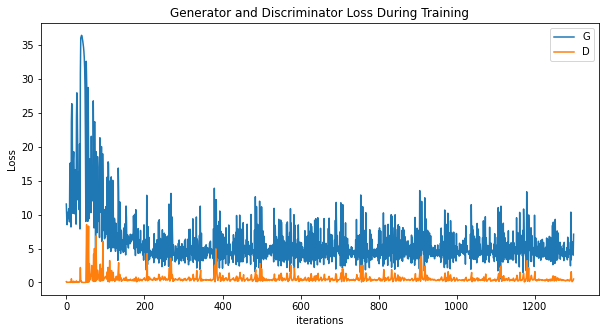

In [47]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [48]:
len(img_list)

4

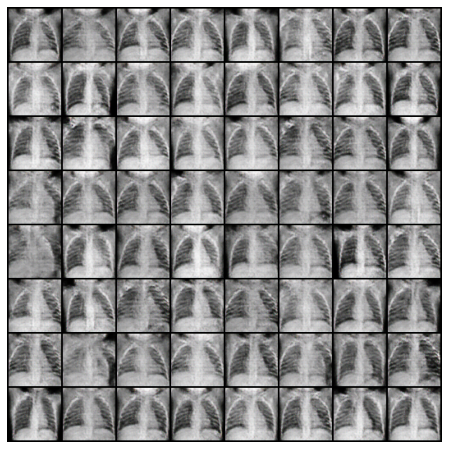

In [49]:
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

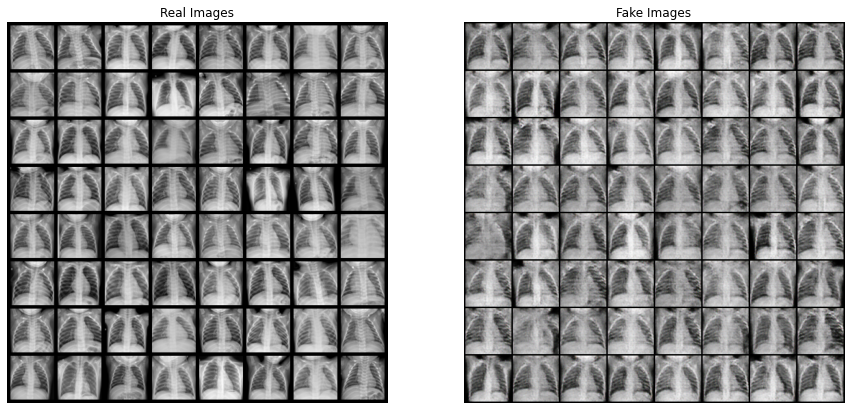

In [50]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
torch.save(netD,'netD.pth')
torch.save(netG,'netG.pth')

In [51]:
fake = netG(fixed_noise).detach().cpu()

In [52]:
img = vutils.make_grid(fake, padding=2, normalize=True)

In [53]:
img_list[-1].shape

torch.Size([3, 530, 530])

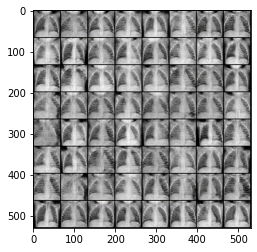

In [54]:
plt.imshow(np.transpose(img,(1,2,0)))

In [55]:
img.shape

torch.Size([3, 530, 530])

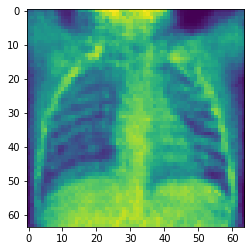

In [56]:
plt.imshow(fake[0][1,:])

In [ ]:
import cv2
os.makedirs("dataset_generator",exist_ok=True)
for i,img_f in enumerate(fake):
    img = np.transpose(img_f,(1,2,0))
    img = img.detach().cpu().numpy()
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.show()
    cv2.imwrite(f"dataset_generator/img_{i}.jpeg",img)

In [102]:
fixed_noise = torch.randn(3000, nz, 1, 1, device=device)
fake = netG(fixed_noise).detach().cpu()

In [103]:
len(fake)

3000

In [104]:
import cv2
os.makedirs("dataset_generator",exist_ok=True)
for i,img_f in enumerate(fake):
    img = np.transpose(img_f,(1,2,0))
    img = img.detach().cpu().numpy()
    # img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    # plt.imshow(img)
    # plt.show()
    cv2.imwrite(f"dataset_generator/img_{i}.jpeg",img)

### train with data dcgan and real dataset

In [105]:
!cp  /content/datasets/data_normal/* /content/dataset_generator
datasets_normal = '/content/dataset_generator'
datasets_pneumonia = "/content/dataset_total_abnormal/abnormal"

In [106]:
def weight_random_sampler(df, train_ds):
    from torch.utils.data import WeightedRandomSampler

    class_counts = df.label.value_counts()
    class_weights = 1 / class_counts
    sample_weights = [class_weights[i] for i in df.label.values]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_ds))

    return sampler

In [107]:
import glob
import os
from typing import List

import numpy as np
import pandas as pd
import PIL
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import transforms as trns


def create_data(save_file: str) -> pd.DataFrame:

    normal_cases_dir = datasets_normal
    pneumonia_cases_dir = datasets_pneumonia

    normal_cases = glob.glob(f"{normal_cases_dir}/*.jpeg")
    pneumonia_cases = glob.glob(f"{pneumonia_cases_dir}/*.jpeg")

    data = []
    print(len(normal_cases))
    for img in normal_cases:
        data.append((img, 0))

    for img in pneumonia_cases:
        data.append((img, 1))

    data = pd.DataFrame(data, columns=["image", "label"], index=None)

    data = data.sample(frac=1.0).reset_index(drop=True)

    os.makedirs("data_chestxray", exist_ok=True)
    data.to_csv(os.path.join("data_chestxray/", save_file), index=False)
    return data


def data_augmentations(img_size: float = 224):
    """
    It takes an image, resizes it to 224x224, flips it horizontally, converts it to a tensor, and
    normalizes it

    :param img_size: The size of the image to be resized to, defaults to 224
    :type img_size: float (optional)
    :return: the train_transforms, val_transforms, and test_transforms.
    """

    train_transforms = trns.Compose(
        [
            trns.CenterCrop(img_size),
            trns.RandomHorizontalFlip(),
            trns.RandomVerticalFlip(),
            trns.ToTensor(),
            trns.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    val_transforms = trns.Compose(
        [
            trns.Resize(size=img_size),
            trns.ToTensor(),
            trns.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    test_transforms = trns.Compose(
        [
            trns.Resize(size=img_size),
            trns.ToTensor(),
            trns.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    return train_transforms, val_transforms, test_transforms


class ChestXrayDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transforms: List = None) -> None:
        """
        This function takes in a dataframe and a list of transforms and assigns the dataframe to the
        class variable df and the list of transforms to the class variable transforms

        :param df: The dataframe containing the data
        :type df: pd.DataFrame
        :param transforms: List = None
        :type transforms: List
        """
        self.df = df
        self.transforms = transforms
        self.labels = self.get_labels()

    def get_labels(self):
        labels = self.df["label"].values
        return labels

    def __len__(self):
        """
        The function returns the number of rows in the dataframe
        :return: The number of rows in the dataframe.
        """
        return self.df.shape[0]

    def _get_image(self, path) -> PIL.Image:
        """
        It takes a path to an image, opens it, converts it to RGB, and returns the image

        :param path: The path to the image you want to classify
        :return: The image data is being returned.
        """
        imageData = Image.open(path).convert("RGB")
        return imageData

    def __getitem__(self, index: int):
        """
        It takes an index as input, and returns a tuple of the image and the target label

        :param index: the index of the image in the dataset
        :type index: int
        :return: The image and the target
        """
        target = self.labels[index]
        img = self._get_image(self.df.loc[index]["image"])
        if self.transforms:
            img = self.transforms(img)
        return img, target


def prepare_dataloader(df: pd.DataFrame, trn_idx: np.ndarray, val_idx: np.ndarray):
    """
    > We take the training and validation indices, and use them to create two datasets, one for training
    and one for validation. We then create two dataloaders, one for training and one for validation

    :param df: the dataframe containing the image paths and labels
    :type df: pd.DataFrame
    :param trn_idx: the indices of the training set
    :type trn_idx: np.ndarray
    :param val_idx: the validation indices
    :type val_idx: np.ndarray
    :return: train_loader and val_loader
    """
    train_ = df.loc[trn_idx, :].reset_index(drop=True)
    valid_ = df.loc[val_idx, :].reset_index(drop=True)

    train_transforms, val_transforms, test_transforms = data_augmentations(img_size=224)

    train_ds = ChestXrayDataset(df=train_, transforms=train_transforms)
    valid_ds = ChestXrayDataset(df=valid_, transforms=train_transforms)


    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=16,
        pin_memory=False,
        drop_last=False,
        shuffle=False,
        num_workers=2,
        # sampler=ImbalancedDatasetSampler(train_ds)
        sampler=weight_random_sampler(df=train_, train_ds=train_ds),
    )

    val_loader = torch.utils.data.DataLoader(
        valid_ds,
        batch_size=4,
        num_workers=2,
        shuffle=False,
        pin_memory=False,
        # sampler=ImbalancedDatasetSampler(valid_ds)
        sampler=weight_random_sampler(df=valid_, train_ds=valid_ds),
    )
    return train_loader, val_loader


In [108]:
data = create_data(save_file="dataset.csv")

4593


0    4593
1    4283
Name: label, dtype: int64


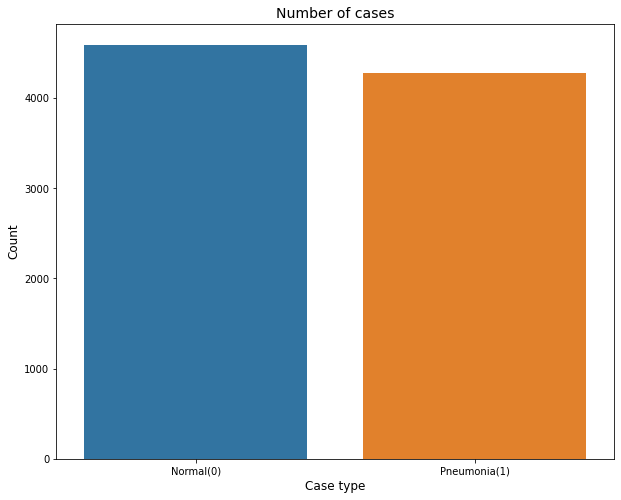

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns 

cases_count = data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [110]:
!pip install timm
import timm
import torch.nn as nn


# > We're creating a classifier that takes in a model architecture, number of classes, and a
# pretrained flag.
#
# The classifier class inherits from the nn.Module class. This is a class that PyTorch provides to
# help us create our own neural network modules.
#
# The classifier class has two methods:
#
# 1. __init__: This is the constructor method. It's called when we create an instance of the
# classifier class.
# 2. forward: This is the method that's called when we pass data through the classifier.
#
# Let's look at the __init__ method first.
#
# The first line of the __init__ method is:
class Classifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(n_features, n_class), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 20.2 MB/s eta 0:00:00


In [111]:
!pip install wandb
import time

import numpy as np
import torch
from sklearn.metrics import (confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.cuda.amp import autocast
from tqdm import tqdm
import wandb


def train_one_epoch(
    epoch: int,
    model: Classifier,
    loss_fn,
    optimizer: torch.optim,
    train_loader: torch.utils.data.DataLoader,
    device: torch.device,
) -> float:
    """
    > We iterate through the training data, and for each batch, we pass the images through the model,
    calculate the loss, and update the model parameters

    :param epoch: the current epoch number
    :param model: the model we're training
    :param loss_fn: the loss function to use
    :param optimizer: The optimizer to use for training
    :param train_loader: the training data loader
    :param device: the device to run the training on
    :return: The average loss per batch
    """

    model.train()

    running_loss = []

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device)
        optimizer.zero_grad()
        image_preds = model(imgs)
        loss = loss_fn(image_preds.squeeze(1), image_labels.float())
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
    return sum(running_loss) / len(running_loss)


def valid_one_epoch(
    epoch: int,
    model: Classifier,
    loss_fn,
    val_loader: torch.utils.data.DataLoader,
    device: torch.device,
    logger,
):
    """
    It takes in the model, the loss function, the validation data loader, the device, the best
    validation accuracy, and the fold number.

    It then runs the model on the validation data, and calculates the validation loss and accuracy.

    If the validation accuracy is better than the best validation accuracy, it saves the model.

    It returns the best validation accuracy.

    :param epoch: the current epoch number
    :param model: the model we're training
    :param loss_fn: the loss function we're using
    :param val_loader: the validation data loader
    :param device: the device to run the training on
    :param best_val: the best validation accuracy we've seen so far
    :param fold: the fold number
    :return: The best validation accuracy
    """
    model.eval()
    validation_loss = 0.0
    image_preds_all = []
    image_targets_all = []

    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).float()

        image_preds = model(imgs)
        image_preds_all += [
            (image_preds.squeeze(1) > 0.5).float().detach().cpu().numpy()
        ]
        image_targets_all += [image_labels.detach().cpu().numpy()]

        loss = loss_fn(image_preds.squeeze(1), image_labels)

        validation_loss += loss.item()

    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)

    logger.info("image_preds_all: {}".format(image_preds_all))
    logger.info("image_targets_all: {}".format(image_targets_all))

    valid_acc = (image_preds_all == image_targets_all).mean()
    valid_f1 = f1_score(
        y_true=image_targets_all, y_pred=image_preds_all, average="binary"
    )
    valid_precision = precision_score(
        y_true=image_targets_all, y_pred=image_preds_all, average="binary"
    )
    valid_recall = recall_score(
        y_true=image_targets_all, y_pred=image_preds_all, average="binary"
    )
    confusionmatrix = confusion_matrix(y_true=image_targets_all, y_pred=image_preds_all)

    wandb.log(
        {
            "acc-valid": valid_acc,
            "F1-valid": valid_f1,
            "precision-valid": valid_precision,
            "recall-valid": valid_recall,
        }
    )
    wandb.log(
        {
            "conf_mat": wandb.plot.confusion_matrix(probs=None,
                preds=image_preds_all,
                y_true=image_targets_all,
                class_names=["Normal", "Pneumonia"],
            )
        }
    )

    logger.info("validation  accuracy = {:.4f}".format(valid_acc))
    logger.info("Validation F1-Score = {:.4f}".format(valid_f1))
    logger.info("Validation Pecision-Score = {:.4f}".format(valid_precision))
    logger.info("Validation Recall-Score = {:.4f}".format(valid_recall))
    logger.info("Confusion matrix = {}".format(confusionmatrix))

    return validation_loss / len(val_loader)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=c7e1ff4d40a83735e37784e794401b241e4537cc54caad89c3a10eab43e6b4fe
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [ ]:
import os
import logging

import numpy as np
import torch
import wandb
from sklearn.model_selection import StratifiedKFold
from torch import nn
from torch.cuda.amp import GradScaler
from tqdm import tqdm
os.makedirs('logs',exist_ok=True)

logging.basicConfig(
    filename="logs/train.log",
    filemode="a",
    format="%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

def main():
    wdb = wandb.init(
        project="pneumonia_chestxray",
        config={
            "optimizer": "AdamW",
            "learning_rate": 0.0005,
            "architecture": "mobilenetv3_large_100",
            "epochs": 30,
            "Loss": "BCEWithLogitsLoss",
            "dataset": "GAN FAKE"
        },
    )
    logging.info("Create dataset")
    device = torch.device("cuda")

    #change link datasets
    dataset = create_data(save_file="dataset.csv")
    folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=1).split(
        np.arange(dataset.shape[0]), dataset.label.values
    )
    for fold, (trn_idx, val_idx) in enumerate(folds):
        if fold > 0:
            break

        train_loader, val_loader = prepare_dataloader(
            df=dataset, trn_idx=trn_idx, val_idx=val_idx
        )
        logging.info("Load model mobilenetv3_large_100")
        model = Classifier(
            model_arch="mobilenetv3_large_100", n_class=1, pretrained=True
        ).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

        # loss = get_weighted_loss(pos_weights=[0.2703210382513661],neg_weights=[0.7296789617486339])
        # loss = FocalLoss(gamma=0.5,alpha=0.25).to(device)
        loss = nn.BCELoss().to(device)

        for epoch in range(30):
            running_loss = train_one_epoch(
                epoch=epoch,
                model=model,
                loss_fn=loss,
                optimizer=optimizer,
                train_loader=train_loader,
                device=device,
            )
            description = f"epoch {epoch} loss: {running_loss:.4f}"
            logging.info("TRAIN: {}".format(description))
            validation_loss = valid_one_epoch(
                epoch=epoch,
                model=model,
                loss_fn=loss,
                val_loader=val_loader,
                device=device,
                logger=logging,
            )
            description = f"epoch {epoch} loss: {validation_loss:.4f}"
            wdb.log({"loss-train": running_loss, "loss-valid": validation_loss})
            logging.info("VALID: {}".format(description))
            scheduler.step()

            os.makedirs("./saved_model",exist_ok=True)
            torch.save(
                model.state_dict(),
                "saved_model/fake_{}_fold_{}_{}.pt".format(
                    "mobilenetv3_large_100", fold, epoch
                ),
            )

        del model, optimizer, train_loader, val_loader, scheduler
        torch.cuda.empty_cache()


if __name__ == "__main__":
    main()
    #api wandb: 6e8a28dad765e9632003f8ba8c03432344f028c6

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


4593


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv3_large_100_ra-f55367f5.pth" to /root/.cache/torch/hub/checkpoints/mobilenetv3_large_100_ra-f55367f5.pth
 45%|████▍     | 166/370 [00:29<00:47,  4.28it/s]